In [1]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

In [11]:
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
GROQ_API_KEY

'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'

In [27]:
import os
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
import json


In [28]:
load_dotenv()


@tool
def search_tool(query: str) -> str:
    """Searches using Tavily and returns results."""
    search = TavilySearchResults(max_results=2)
    results = search.invoke(query)
    return results

# Define the analyze query tool using Groq
@tool
def analyze_query(query: str) -> str:
    """Analyzes the query using the Groq model."""
    llm = ChatGroq(
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7,
        model_name="mixtral-8x7b-32768"
    )
    response = llm.invoke(query)
    return response.content

In [32]:

search_tool("What is the weather in San Francisco")


[{'url': 'https://www.weatherapi.com/',
  'content': "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.775, 'lon': -122.4183, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1737206582, 'localtime': '2025-01-18 05:23'}, 'current': {'last_updated_epoch': 1737206100, 'last_updated': '2025-01-18 05:15', 'temp_c': 8.3, 'temp_f': 46.9, 'is_day': 0, 'condition': {'text': 'Fog', 'icon': '//cdn.weatherapi.com/weather/64x64/night/248.png', 'code': 1135}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 53, 'wind_dir': 'NE', 'pressure_mb': 1025.0, 'pressure_in': 30.27, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 98, 'cloud': 100, 'feelslike_c': 8.3, 'feelslike_f': 46.9, 'windchill_c': 8.3, 'windchill_f': 46.9, 'heatindex_c': 8.3, 'heatindex_f': 46.9, 'dewpoint_c': 7.4, 'dewpoint_f': 45.3, 'vis_km': 10.0, 'vis_miles': 6.0, 'uv': 0.0, 'gust_mph': 3.7, 'gust_kph': 5.9}}"},
 {'url': 'https://world-weather.info/forecast/usa/san_fra

In [33]:
def setup_agent():
    """Set up the agent with the new tools."""
    llm = ChatGroq(
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7,
        model_name="mixtral-8x7b-32768"
    )

    tools = [search_tool, analyze_query]
    memory = MemorySaver()
    
    system_message = """You are an agent that can search and analyze queries. Use the tools effectively."""
    
    return create_react_agent(llm, tools, checkpointer=memory)

# Create the agent
agent_executor = setup_agent()


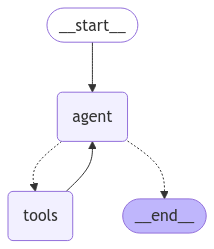

In [34]:
agent_executor

In [37]:
# Function to interact with the agent
def interact_with_agent(message: str, thread_id: str):
    """Interact with the agent and return the response."""
    config = {"configurable": {"thread_id": thread_id}}  # Include thread_id in the config
    response = agent_executor.invoke({"messages": [{"role": "user", "content": message}]}, config)
    
    # Extract and print the weather information
    for msg in response['messages']:
        if isinstance(msg, dict) and 'content' in msg:
            if 'tool_calls' in msg.get('additional_kwargs', {}):
                tool_message = msg['additional_kwargs']['tool_calls'][0]
                tool_content = tool_message['content']
                
                # Parse the JSON content
                weather_data = json.loads(tool_content)
                
                # Extract relevant weather information
                for item in weather_data:
                    if 'content' in item:
                        weather_info = json.loads(item['content'])
                        current_weather = weather_info['current']
                        location = weather_info['location']
                        
                        # Print the formatted weather information
                        print(f"🌍 **Location**: {location['name']}, {location['region']}, {location['country']}")
                        print(f"🌡️ **Temperature**: {current_weather['temp_c']}°C ({current_weather['temp_f']}°F)")
                        print(f"☁️ **Condition**: {current_weather['condition']['text']}")
                        print(f"💧 **Humidity**: {current_weather['humidity']}%")
                        print(f"💨 **Wind**: {current_weather['wind_mph']} mph ({current_weather['wind_kph']} kph) from {current_weather['wind_dir']}")
                        print(f"🕒 **Last Updated**: {location['localtime']}")
                        print("\n" + "="*50 + "\n")  # Separator for readability
    
    return response

# Test the agent with a search query
thread_id = "unique_thread_1"  # You can change this for different interactions
interact_with_agent("What is the weather in San Francisco?", thread_id)

{'messages': [HumanMessage(content='What is the weather in San Francisco?', additional_kwargs={}, response_metadata={}, id='4f3886d9-1f18-4af8-b176-c4fb3ef3404b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hndm', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'search_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1318, 'total_tokens': 1411, 'completion_time': 0.14378, 'prompt_time': 0.149953324, 'queue_time': 0.055932834000000015, 'total_time': 0.293733324}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b6e27757-0691-48ee-96fd-a73fcda32137-0', tool_calls=[{'name': 'search_tool', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_hndm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1318, 'output_tokens': 93, 'total_tokens': 1411}),
  ToolMessage(content='[{"url": "https

In [36]:
search_response

{'messages': [HumanMessage(content='What is the weather in San Francisco?', additional_kwargs={}, response_metadata={}, id='4f3886d9-1f18-4af8-b176-c4fb3ef3404b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hndm', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'search_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 93, 'prompt_tokens': 1318, 'total_tokens': 1411, 'completion_time': 0.14378, 'prompt_time': 0.149953324, 'queue_time': 0.055932834000000015, 'total_time': 0.293733324}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b6e27757-0691-48ee-96fd-a73fcda32137-0', tool_calls=[{'name': 'search_tool', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_hndm', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1318, 'output_tokens': 93, 'total_tokens': 1411}),
  ToolMessage(content='[{"url": "https

In [40]:
# Import necessary libraries
import os
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage
import json

# Load environment variables from .env file
load_dotenv()

# Define the search tool using Tavily
@tool
def search_tool(query: str) -> str:
    """Searches using Tavily and returns results."""
    search = TavilySearchResults(max_results=2)
    results = search.invoke(query)
    return results

# Define the analyze query tool using Groq
@tool
def analyze_query(query: str) -> str:
    """Analyzes the query using the Groq model."""
    llm = ChatGroq(
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7,
        model_name="mixtral-8x7b-32768"
    )
    response = llm.invoke(query)
    return response.content

# Set up the agent with the defined tools
def setup_agent():
    """Set up the agent with the new tools."""
    llm = ChatGroq(
        api_key=os.getenv("GROQ_API_KEY"),
        temperature=0.7,
        model_name="mixtral-8x7b-32768"
    )

    tools = [search_tool, analyze_query]
    memory = MemorySaver()
    
    system_message = """You are an agent that can search and analyze queries. Use the tools effectively."""
    
    return create_react_agent(llm, tools, checkpointer=memory)

# Create the agent
agent_executor = setup_agent()

# Function to interact with the agent
def interact_with_agent(message: str, thread_id: str):
    """Interact with the agent and return the response in a straightforward format."""
    config = {"configurable": {"thread_id": thread_id}}  # Include thread_id in the config
    response = agent_executor.invoke({"messages": [{"role": "user", "content": message}]}, config)
    
    # Extract and format the weather information
    for msg in response['messages']:
        if isinstance(msg, dict) and 'content' in msg:
            if 'tool_calls' in msg.get('additional_kwargs', {}):
                tool_message = msg['additional_kwargs']['tool_calls'][0]
                tool_content = tool_message['content']
                
                # Parse the JSON content
                weather_data = json.loads(tool_content)
                
                # Extract relevant weather information
                for item in weather_data:
                    if 'content' in item:
                        weather_info = json.loads(item['content'])
                        current_weather = weather_info['current']
                        location = weather_info['location']
                        
                        # Format the output
                        formatted_output = (
                            f"The weather in {location['name']}, {location['region']} is "
                            f"{current_weather['condition']['text'].lower()} with a temperature of "
                            f"{current_weather['temp_c']} degrees Celsius ({current_weather['temp_f']} degrees Fahrenheit)."
                        )
                        print(formatted_output)
                        print("\n" + "="*50 + "\n")  # Separator for readability
    
    return response

# Test the agent with a search query
thread_id = "unique_thread_1"  # You can change this for different interactions
search_response = interact_with_agent("hi my name is prashant?", thread_id)

search_response

{'messages': [HumanMessage(content='hi my name is prashant?', additional_kwargs={}, response_metadata={}, id='6e17ef8c-51b5-42a1-8d91-4e7ba2f3c8e8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mxv7', 'function': {'arguments': '{"query":"Prashant popular baby names"}', 'name': 'search_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 108, 'prompt_tokens': 1318, 'total_tokens': 1426, 'completion_time': 0.166404692, 'prompt_time': 0.086301438, 'queue_time': 0.019283881000000003, 'total_time': 0.25270613}, 'model_name': 'mixtral-8x7b-32768', 'system_fingerprint': 'fp_c5f20b5bb1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-e8524d10-ae34-4ac1-85dd-61998438c588-0', tool_calls=[{'name': 'search_tool', 'args': {'query': 'Prashant popular baby names'}, 'id': 'call_mxv7', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1318, 'output_tokens': 108, 'total_tokens': 1426}),
  ToolMessage(content='[{"url": "https://

In [43]:
thread_id = "unique_thread_1"  # You can change this for different interactions
search_response = interact_with_agent("wagt is my name ", thread_id)



print(f"ContentString: {search_response.content}")
print(f"ToolCalls: {search_response.tool_calls}")

AttributeError: 'AddableValuesDict' object has no attribute 'content'